In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from custom_function import DicodingProject2 as DP2
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models # type:ignore
from tensorflow.keras.models import load_model  # type: ignore

2025-02-27 13:53:28.970251: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 13:53:29.217643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740639209.333489   78016 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740639209.366975   78016 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 13:53:29.651630: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
dataset = load_dataset('sagecontinuum/smokedataset', split='train') # Use train split only, because already alot data
print(dataset) # There are more than 14k images. Amannn
label_mapping = {idx : label for idx, label in enumerate(dataset.features['label'].names)}
print(label_mapping) # 3 or more classes. Amannn

Dataset({
    features: ['image', 'label'],
    num_rows: 14318
})
{0: 'cloud', 1: 'other', 2: 'smoke'}


In [3]:
pd.Series(dataset['label'], name='label').replace(label_mapping).value_counts()

label
other    5723
cloud    4358
smoke    4237
Name: count, dtype: int64

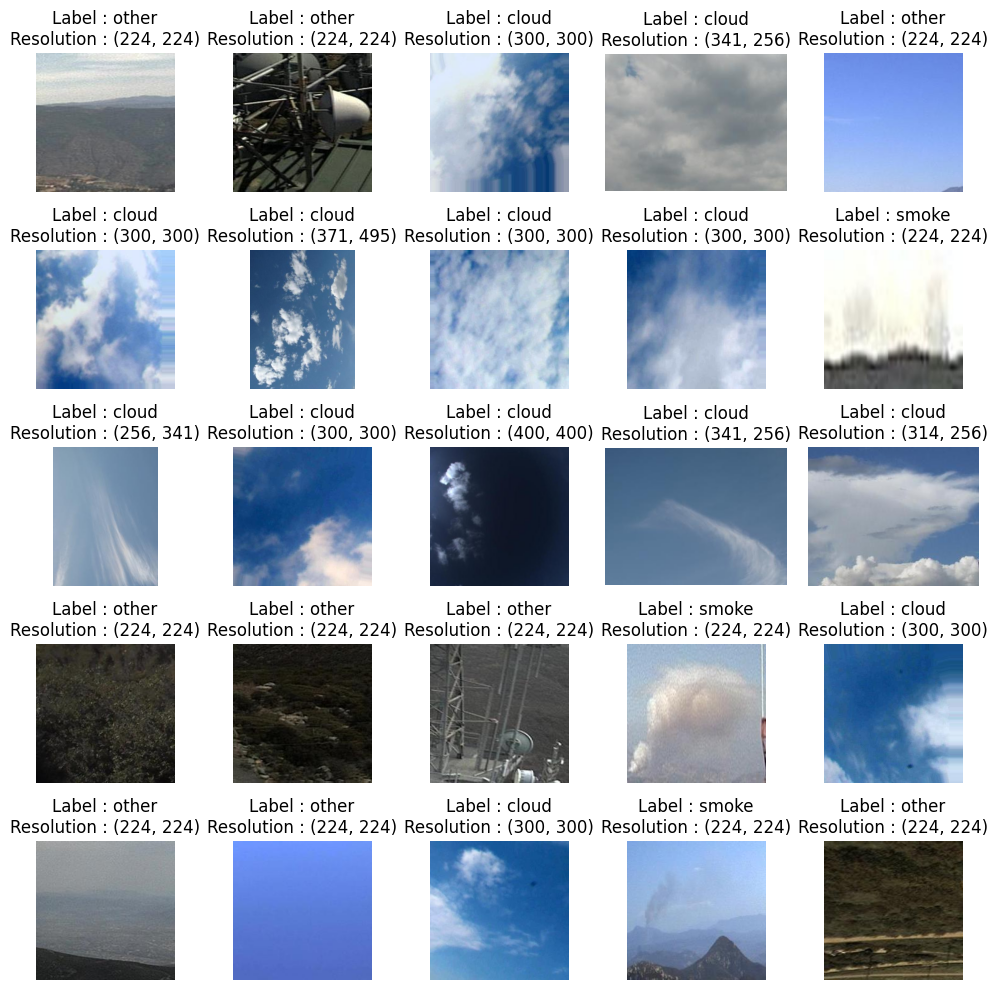

In [4]:
DP2.showImages([(dataset[i]['image'], dataset[i]['label']) for i in random.sample(range(len(dataset)), 25)], label_mapping)
# Several images have different resolution!

In [5]:
dataset_preprocessed = dataset.map(DP2.preprocessImage, remove_columns=['image'], batched=True, batch_size=64)
dataset_preprocessed, dataset_preprocessed[0]['resized_image'].size

(Dataset({
     features: ['label', 'resized_image'],
     num_rows: 14318
 }),
 (128, 128))

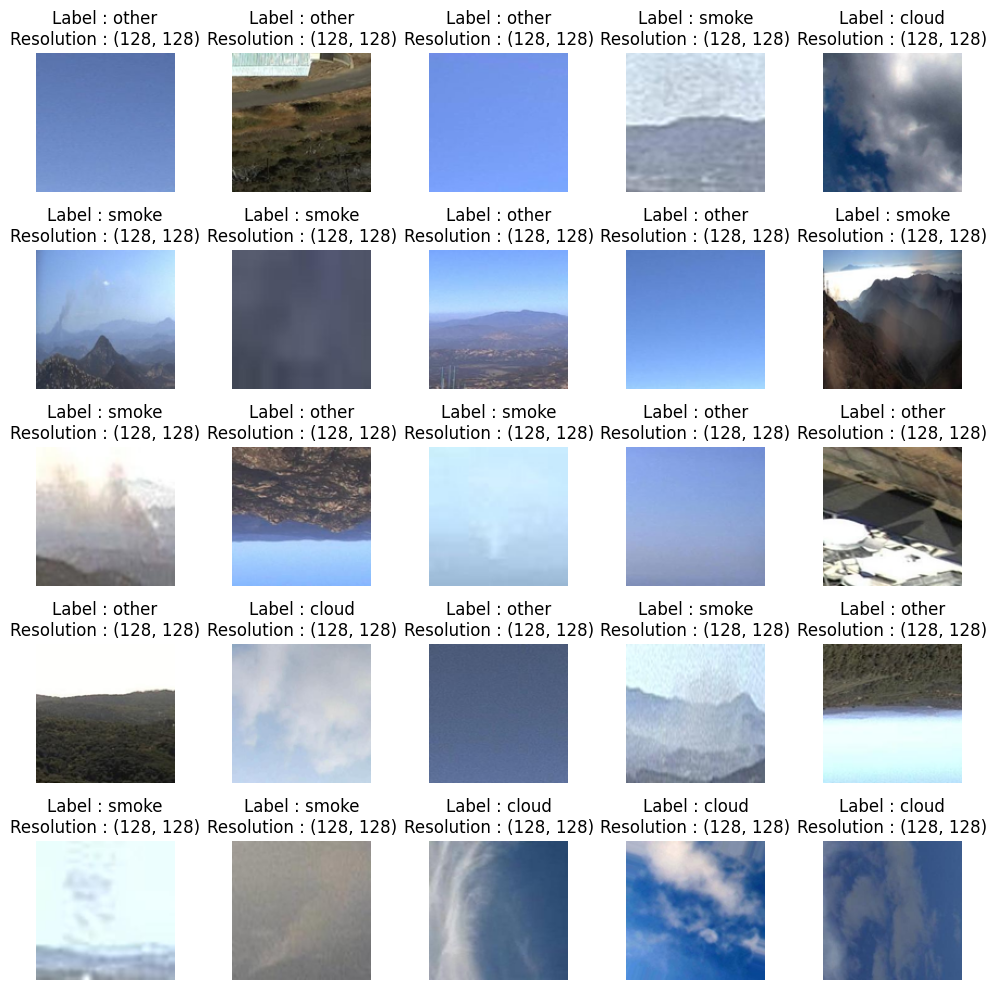

In [6]:
DP2.showImages2([(dataset_preprocessed[i]['resized_image'], dataset_preprocessed[i]['label']) for i in random.sample(range(len(dataset)), 25)], label_mapping)
# All images now have same resolution!

In [7]:
split_dataset = dataset_preprocessed.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)
temp_dataset = split_dataset['test'].train_test_split(test_size=0.5, stratify_by_column='label', seed=42)

train_dataset = split_dataset["train"]
val_dataset = temp_dataset["train"]
test_dataset = temp_dataset["test"]

In [8]:
train_dataset, test_dataset, val_dataset # Check after splitting

(Dataset({
     features: ['label', 'resized_image'],
     num_rows: 11454
 }),
 Dataset({
     features: ['label', 'resized_image'],
     num_rows: 1432
 }),
 Dataset({
     features: ['label', 'resized_image'],
     num_rows: 1432
 }))

In [9]:
print("Convert train")
X_train, y_train = DP2.convert2Numpy(train_dataset)
print("Convert test")
X_test, y_test = DP2.convert2Numpy(test_dataset)
print("Convert val")
X_val, y_val = DP2.convert2Numpy(val_dataset)

Convert train
Convert test
Convert val


In [10]:
X_train_resampled, y_train_resampled = DP2.resampling(X_train, y_train) # Make train data balance using ROS
X_train_resampled.shape, y_train_resampled.shape

((13734, 128, 128, 3), (13734,))

In [11]:
train_dataset = DP2.toTfDataset(X_train_resampled, y_train_resampled, shuffle=True)
test_dataset = DP2.toTfDataset(X_test, y_test, shuffle=False)
val_dataset = DP2.toTfDataset(X_val, y_val, shuffle=False)

train_dataset, test_dataset, val_dataset # create tf dataset

I0000 00:00:1740639242.445093   78016 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [12]:
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy'] 
)

In [13]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[DP2.checkpointCallback(), DP2.earlyStopping()]
)

Epoch 1/100


I0000 00:00:1740639248.172115   78203 service.cc:148] XLA service 0x7f70b4004a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740639248.174596   78203 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-02-27 13:54:08.210444: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740639248.439396   78203 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/215 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5358 - loss: 0.9454

I0000 00:00:1740639253.148156   78203 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8083 - loss: 0.4703
Epoch 1: val_accuracy improved from -inf to 0.90293, saving model to ./saved_model/best_model.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.8086 - loss: 0.4698 - val_accuracy: 0.9029 - val_loss: 0.2489
Epoch 2/100
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9164 - loss: 0.2202
Epoch 2: val_accuracy improved from 0.90293 to 0.93017, saving model to ./saved_model/best_model.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9165 - loss: 0.2199 - val_accuracy: 0.9302 - val_loss: 0.1623
Epoch 3/100
213/215 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9497 - loss: 0.1335
Epoch 3: val_accuracy improved from 0.93017 to 0.95251, saving model to ./saved_model/best_model.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9498 - loss: 0.1333 - val_accuracy: 0.9525 - val_loss: 0.1407
Epoch 4/100
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9663 - loss: 0.092

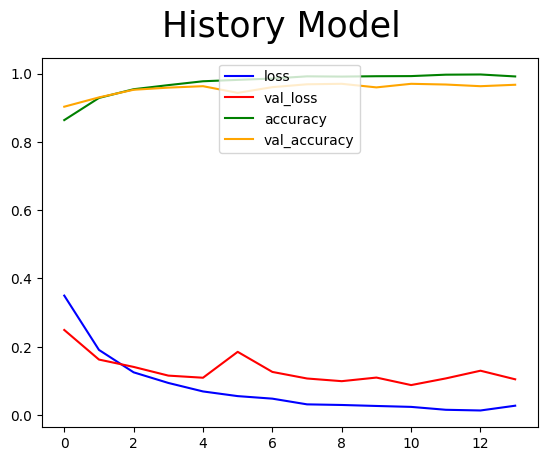

In [14]:
figg = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='val_loss')
plt.plot(history.history['accuracy'], color='green', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
figg.suptitle('History Model', fontsize='25')
plt.legend(loc='upper center')
plt.show()

In [15]:
best_model = load_model('./saved_model/best_model.keras')
result = best_model.predict(test_dataset)
predicted_labels = np.argmax(result, axis=1)
accuracy = accuracy_score(y_test, predicted_labels)
print(f'Akurasi model adalah {accuracy}') # Accuracy testing over 95% 

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Akurasi model adalah 0.9636871508379888
